A notebook to demonstrate the importance of parameterization in designing feature spaces. Feature space implicitely reflect hypotheses about representation, and how the features are parameterized instantiates the actual form of that hypothesis.

Here we use a toy example of two different parameterizations of location to model  the activity of place cells. Obviously this is an exaggerated example, but it gets the point across.

In [48]:
from ratinabox.Environment import Environment
from ratinabox.Agent import Agent
from ratinabox.Neurons import PlaceCells

from himalaya.ridge import RidgeCV
from himalaya.scoring import r2_score as R2, correlation_score as Correlation

import numpy

from plotly import graph_objects as plots, offline as plot
plot.init_notebook_mode()

renderer = 'png' # change to "notebook" or "vscode" for getting interactive figures

We use the Rat-In-A-Box package to simulate place cell recordings from a rat running around in an enclosure

In [49]:
world = Environment({'scale': 2})
rat = Agent(world)
placeCells = PlaceCells(rat)

By default, we record from 10 virtual neurons. These are the ground-truth place fields of these place cells.

(<Figure size 3600x360 with 20 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

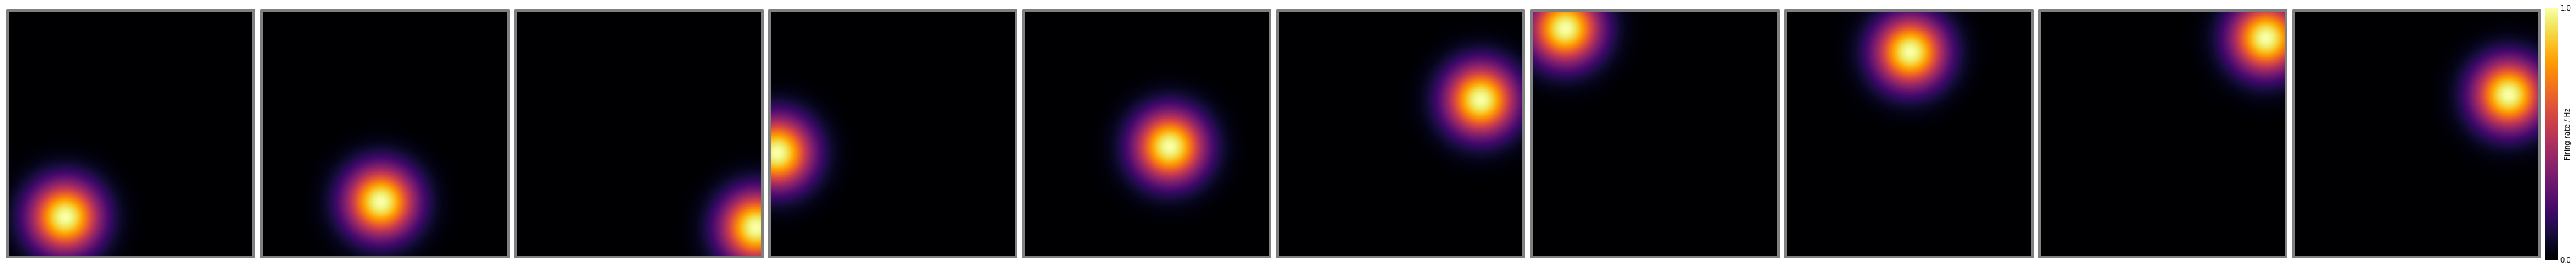

In [50]:
placeCells.plot_rate_map()

We let the rat run around for a bit and record neural activity

In [51]:
for i in range(20000):
	rat.update()
	placeCells.update()

For sanity, look at the rat trajectory

(<Figure size 360x360 with 1 Axes>, <Axes: >)

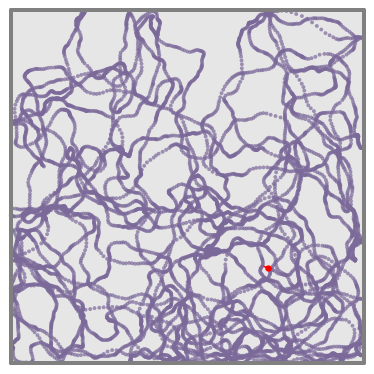

In [52]:
rat.plot_trajectory()

And plot the recorded neural activity in firing rate across time

(<Figure size 360x129.6 with 1 Axes>,
 <Axes: xlabel='Time / min', ylabel='Neurons'>)

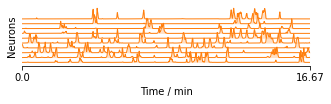

In [53]:
placeCells.plot_rate_timeseries()

We take the data out of these objects and put them into numpy arrays

In [54]:
position = numpy.array(rat.history['pos'])
activity = numpy.array(placeCells.history['firingrate'])

Here, we are trying to model the activity of place cells in the rat hippocampus. The conceptual hypothesis can be stated as "hippocampal neurons encode location information." However, the specific hypothesis lies in how location information is parametrized as features in our models.

If we take the (X, Y) locations of the rat across time as features for fitting models, then location is encoded as two continuous variables. The specific hypothesis is then "hippocampal neurons encode location as continuous coordinate variables along orthogonal spatial dimensions."

Given our prior knowledge about how the hippocampus works, we can also grid the enclosure up into spatial bins; each bin has a corresponding boolean variable that indicates whether the rat is in that bin, i.e. location is encoded one-hot/indicator variable manner. The specific hypothesis is then "hippocampal neurons encode location as one-hot variables that tile physical space."

If we look at the traces of these features, we can see that they look very different.

In [55]:
def MakeBins(data, nBins, max = 2):
	"""
	A function to turn continous location vars into bins
	"""
	out = numpy.zeros([data.shape[0], nBins ** 2])
	isX = []
	isY = []
	for i in range(nBins):
		low = max *  i / nBins
		high = max * (i + 1) / nBins
		isX.append(numpy.logical_and(data[:, 0] > low, data[:, 0] <= high))
		isY.append(numpy.logical_and(data[:, 1] > low, data[:, 1] <= high))
	index = 0
	for i in range(nBins):
		for j in range(nBins):
			out[:, index] = numpy.logical_and(isX[i], isY[j])
			index += 1
	return out

In [56]:
# we do something a bit fancy and use a pyramid of bins of different sizes
binned = numpy.hstack([MakeBins(position, b) for b in [4, 8, 16, 32]])

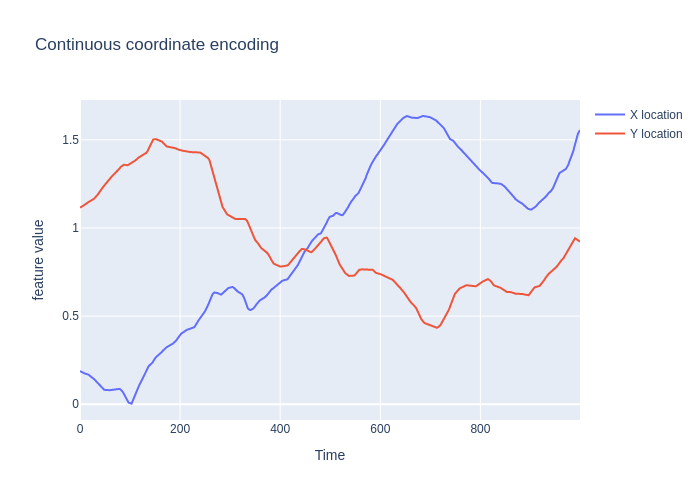

In [57]:
plotData = [plots.Scatter(y = position[:1000, 0], name = 'X location'),
			plots.Scatter(y = position[:1000, 1], name = 'Y location')]
layout = plots.Layout(xaxis = {'title': 'Time'}, yaxis = {'title': 'feature value'},
					  title = 'Continuous coordinate encoding')
figure = plots.Figure(data = plotData, layout = layout)
figure.show(renderer = renderer)

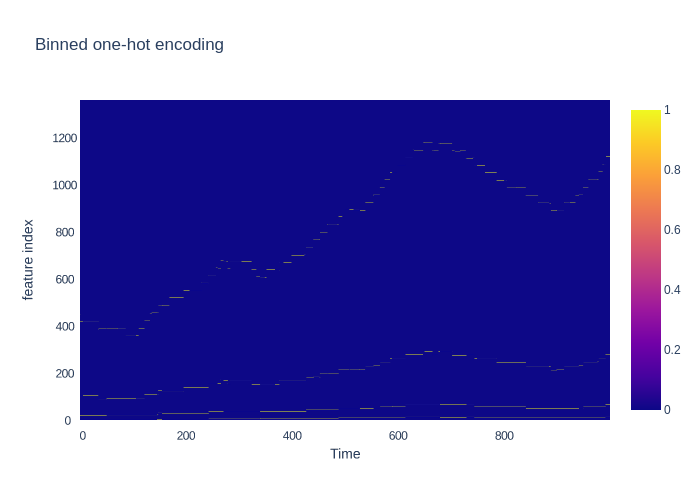

In [58]:
plotData = [plots.Heatmapgl(z = binned[:1000, :].transpose(), name = 'binned encoding')]
layout = plots.Layout(xaxis = {'title': 'Time'}, yaxis = {'title': 'feature index'},
					  title = 'Binned one-hot encoding')
figure = plots.Figure(data = plotData, layout = layout)
figure.show(renderer = renderer)

We break the features and data up onto train/test sets

In [59]:
trainPos = position[:15000, :]
testPos = position[15000:, :]

trainBins = binned[:15000, :]
testBins = binned[15000:, :]

trainData = activity[:15000, :]
testData = activity[15000:, :]

In [60]:
def demean(train, test):
	"""
	De-means values because we don't fit with an intercept
	"""
	outTrain = numpy.zeros_like(train)
	outTest = numpy.zeros_like(test)
	means = numpy.mean(train, axis = 0)
	for i in range(train.shape[1]):
		outTrain[:, i] = train[:, i] - means[i]
		outTest[:, i] = test[:, i] - means[i]
	return outTrain, outTest

In [61]:
trainPosCentered, testPosCentered = demean(trainPos, testPos)
trainBinsCentered, testBinsCentered = demean(trainBins, testBins)
trainDataCentered, testDataCentered = demean(trainData, testData)

Fit models to the two parametrizations

In [62]:
continuousModel = RidgeCV(alphas = numpy.logspace(-4, 7, 12))
_ = continuousModel.fit(trainPosCentered, trainDataCentered)
scalarPreds = continuousModel.predict(testPosCentered)
scalarScores = continuousModel.score(testPosCentered, testDataCentered)

binModel = RidgeCV(alphas = numpy.logspace(-4, 7, 12))
_ = binModel.fit(trainBinsCentered, trainDataCentered)
binPreds = binModel.predict(testBinsCentered)
binScores = binModel.score(testBinsCentered, testData)

Look at the model predictions for the two parametrizations

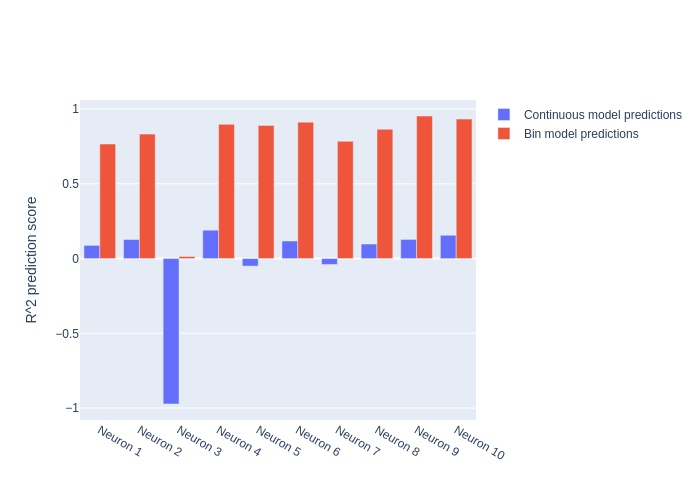

In [63]:
plotData = [plots.Bar(x = ['Neuron {}'.format(i + 1) for i  in range(10)],
						y = scalarScores, name = 'Continuous model predictions'),
			plots.Bar(x = ['Neuron {}'.format(i + 1) for i  in range(10)],
						y = binScores, name = 'Bin model predictions')]
layout = plots.Layout(yaxis = {'title': 'R^2 prediction score'})
figure = plots.Figure(data = plotData, layout = layout)
figure.show(renderer = renderer)

So the bin models outperform the continous models on every neuron and can explain almost 100% of the variance in some neurons. But what's up with the very negative performances? We can look at the raw test data and the predicted activity traces.

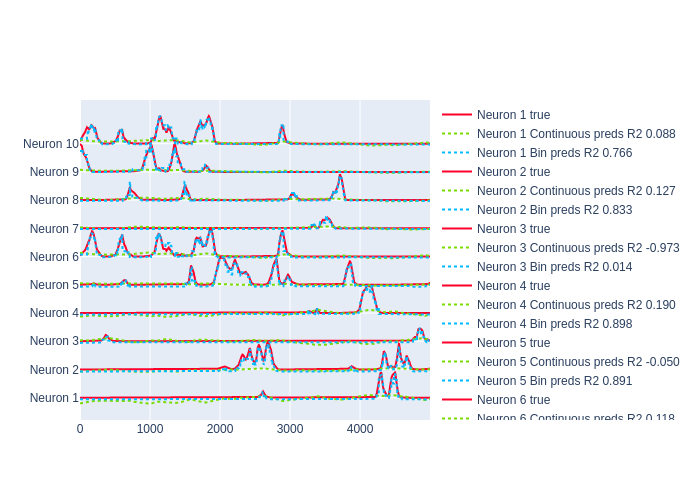

In [64]:
plotData = []
for i in range(10):
	plotData.append(plots.Scatter(y = testData[:, i] + i + 1, mode = 'lines', line = {'width': 2, 'color': 'rgb(255, 0, 42)'},
									name = 'Neuron {} true'.format(i + 1),))
	plotData.append(plots.Scatter(y = scalarPreds[:, i] + i + 1, mode = 'lines', 
									line = {'width': 2, 'color': 'rgb(120, 220, 0)', 'dash': 'dot'},
									name = 'Neuron {} Continuous preds R2 {:.3f}'.format(i + 1, scalarScores[i])))
	plotData.append(plots.Scatter(y = binPreds[:, i] + i + 1, mode = 'lines', 
									line = {'width': 2, 'color': 'rgb(0, 187, 255)', 'dash': 'dot'},
									name = 'Neuron {} Bin preds R2 {:.3f}'.format(i + 1, binScores[i])))
layout = plots.Layout(yaxis = {'tickmode': 'array', 'tickvals': list(range(1, 11)),
 								'ticktext': ['Neuron {}'.format(i) for i in range(1, 11)]})
figure = plots.Figure(data = plotData, layout = layout)
figure.show(renderer = renderer)

So it looks like the continouous predictions are actually potato, but the binned values just have a DC offset - R^2 is sensitive to this kind of error. Let's look at correlation instead, which ignores constant offsets and scaling differences.

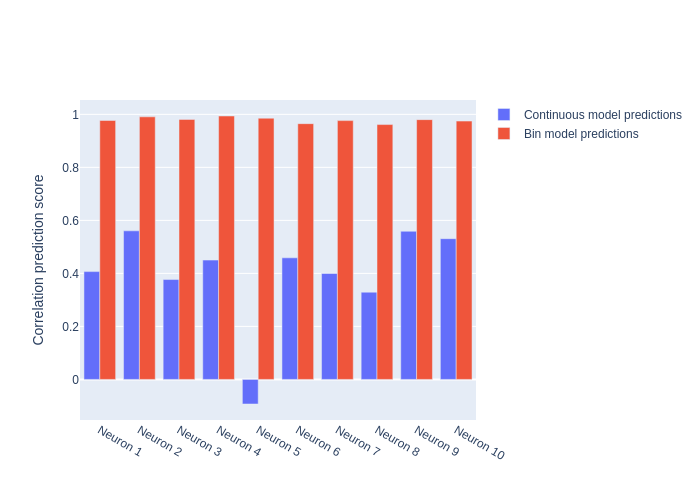

In [65]:
plotData = [plots.Bar(x = ['Neuron {}'.format(i + 1) for i  in range(10)],
						y = Correlation(continuousModel.predict(testPosCentered), testData), name = 'Continuous model predictions'),
			plots.Bar(x = ['Neuron {}'.format(i + 1) for i  in range(10)],
						y = Correlation(binModel.predict(testBinsCentered), testData), name = 'Bin model predictions')]
layout = plots.Layout(yaxis = {'title': 'Correlation prediction score'})
figure = plots.Figure(data = plotData, layout = layout)
figure.show(renderer = renderer)

Ok yeah so the bins approch a correlation of 1 in every neuron. The continuous models are potato compared to the bins.
